In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [211]:
df = pd.read_csv('out_train_v2.csv')

In [212]:
df1 = pd.read_csv('out_test_v2.csv')

In [213]:
X = df.drop("WnvPresent", axis=1)
y = df.WnvPresent

In [214]:
X["TVar"] = X["Tmax"] - X["Tmin"]

In [215]:
df1["TVar"] = df1['Tmax'] - df1['Tmin']

In [216]:
X.head()
X = X.drop(['Unnamed: 0', 'Date', 'Address', 'Block', 'Street', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'Tavg', 'Tmin', 'NumMosquitos', 'DewPoint'], axis=1)

In [217]:
test = df1.drop(['Unnamed: 0','Id', 'Date', 'Address', 'Block', 'Street', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'Tavg', 'Tmin', 'DewPoint'], axis=1)

In [218]:
X.head()

,Species,Trap,Tmax,PrecipTotal,AvgSpeed,length_of_day,TVar
0,CULEX PIPIENS/RESTUANS,T002,88,0.0,6.5,896.0,28
1,CULEX RESTUANS,T002,88,0.0,6.5,896.0,28
2,CULEX RESTUANS,T007,88,0.0,6.5,896.0,28
3,CULEX PIPIENS/RESTUANS,T015,88,0.0,6.5,896.0,28
4,CULEX RESTUANS,T015,88,0.0,6.5,896.0,28


In [219]:
test.head()

,Species,Trap,Tmax,PrecipTotal,AvgSpeed,length_of_day,TVar
0,CULEX PIPIENS/RESTUANS,T002,86,0.0,10.0,910.0,25
1,CULEX RESTUANS,T002,86,0.0,10.0,910.0,25
2,CULEX PIPIENS,T002,86,0.0,10.0,910.0,25
3,CULEX SALINARIUS,T002,86,0.0,10.0,910.0,25
4,CULEX TERRITANS,T002,86,0.0,10.0,910.0,25


In [220]:
X.Species = X.Species.astype('category')
X.Species = X.Species.cat.codes

In [221]:
test.Species = test.Species.astype('category')
test.Species = test.Species.cat.codes

In [222]:
X.dtypes

Species             int8
Trap              object
Tmax               int64
PrecipTotal      float64
AvgSpeed         float64
length_of_day    float64
TVar               int64
dtype: object

In [223]:
X.Trap = X.Trap.astype('category')
X.Trap = X.Trap.cat.codes

In [224]:
test.Trap = test.Trap.astype('category')
test.Trap = test.Trap.cat.codes

In [225]:
X.dtypes

Species             int8
Trap               int16
Tmax               int64
PrecipTotal      float64
AvgSpeed         float64
length_of_day    float64
TVar               int64
dtype: object

In [226]:
test.dtypes

Species             int8
Trap               int16
Tmax               int64
PrecipTotal      float64
AvgSpeed         float64
length_of_day    float64
TVar               int64
dtype: object

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [30]:
X = StandardScaler().fit_transform(X)

In [31]:
test = StandardScaler().fit_transform(test)

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc

In [34]:
knn = KNeighborsClassifier(n_neighbors = 2)

In [35]:
names = ["present", "not present", "predicted present", "predicted not present"]

In [227]:
def evaluate_model(model, X, y, names, test):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=7)
    model = model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    print model.score(X_test, Y_test)
    Y_pp = pd.DataFrame(model.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
    Y_pp['pred_class_thresh10'] = [1 if x >= 0.05 else 0 for x in Y_pp.class_1_pp.values]
    X_test_df = pd.DataFrame(X_test)
    conmat = np.array(confusion_matrix(Y_test, Y_pp.pred_class_thresh10, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=[names[0:2]],
                         columns=[names[2:]]) 
    print(Y_pp.iloc[0:10])
    print confusion
    print(classification_report(Y_test, Y_pp.pred_class_thresh10))
    print Y_pp.shape
    print X_test_df.head()
    
    Y_score = model.decision_function(X_test)

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

# For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(Y_test, Y_score)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    return "cross val mean score is", cross_val_score(model, X_train, Y_train, cv=5).mean()
    
    


evaluate_model(knn, X, y, names, test)

0.942601672916
   class_0_pp  class_1_pp  pred_class_thresh10
0         0.5         0.5                    1
1         1.0         0.0                    0
2         1.0         0.0                    0
3         1.0         0.0                    0
4         1.0         0.0                    0
5         1.0         0.0                    0
6         1.0         0.0                    0
7         1.0         0.0                    0
8         1.0         0.0                    0
9         1.0         0.0                    0
             predicted present  predicted not present
present                     68                    114
not present                319                   2966
             precision    recall  f1-score   support

          0       0.96      0.90      0.93      3285
          1       0.18      0.37      0.24       182

avg / total       0.92      0.88      0.90      3467

(3467, 3)
       Species  Trap  Tmax  PrecipTotal  AvgSpeed  length_of_day  TVar
10156     

AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

In [38]:
model = knn.fit(X, y)
y_pred = model.predict(test)

In [40]:
len(y_pred)

116293

In [78]:
evaluate_model(knn, X1, y, names, test)

0.940871070089
   class_0_pp  class_1_pp  pred_class_thresh10
0         0.0         1.0                    1
1         1.0         0.0                    0
2         1.0         0.0                    0
3         1.0         0.0                    0
4         1.0         0.0                    0
5         1.0         0.0                    0
6         1.0         0.0                    0
7         1.0         0.0                    0
8         1.0         0.0                    0
9         1.0         0.0                    0
             predicted present  predicted not present
present                     57                    125
not present                310                   2975
             precision    recall  f1-score   support

          0       0.96      0.91      0.93      3285
          1       0.16      0.31      0.21       182

avg / total       0.92      0.87      0.89      3467

(3467, 3)
          0         1         2         3         4         5
0 -1.177499  1.3860

AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

In [228]:
rf = RandomForestClassifier(n_jobs=-1, max_features='sqrt')


In [230]:
evaluate_model(rf, X, y, names, test)

0.92529564465
   class_0_pp  class_1_pp  pred_class_thresh10
0        0.34        0.66                    1
1        1.00        0.00                    0
2        1.00        0.00                    0
3        1.00        0.00                    0
4        1.00        0.00                    0
5        1.00        0.00                    0
6        1.00        0.00                    0
7        1.00        0.00                    0
8        1.00        0.00                    0
9        1.00        0.00                    0
             predicted present  predicted not present
present                     93                     89
not present                579                   2706
             precision    recall  f1-score   support

          0       0.97      0.82      0.89      3285
          1       0.14      0.51      0.22       182

avg / total       0.92      0.81      0.85      3467

(3467, 3)
       Species  Trap  Tmax  PrecipTotal  AvgSpeed  length_of_day  TVar
10156      

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [80]:
evaluate_model(rf, X1, y, names)

0.931352754543
   class_0_pp  class_1_pp  pred_class_thresh10
0         0.6         0.4                    1
1         1.0         0.0                    0
2         1.0         0.0                    0
3         1.0         0.0                    0
4         1.0         0.0                    0
5         1.0         0.0                    0
6         1.0         0.0                    0
7         1.0         0.0                    0
8         1.0         0.0                    0
9         1.0         0.0                    0
             predicted present  predicted not present
present                     94                     88
not present                574                   2711
             precision    recall  f1-score   support

          0       0.97      0.83      0.89      3285
          1       0.14      0.52      0.22       182

avg / total       0.93      0.81      0.86      3467

(3467, 3)
          0         1         2         3         4         5
0 -1.177499  1.3860

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [315]:
#gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(max_depth=3, max_features='sqrt', random_state=42)

0.946062878569
   class_0_pp  class_1_pp  pred_class_thresh10
0    0.652562    0.347438                    1
1    0.883501    0.116499                    1
2    0.995924    0.004076                    0
3    0.974021    0.025979                    0
4    0.954346    0.045654                    0
5    0.984168    0.015832                    0
6    0.991891    0.008109                    0
7    0.997863    0.002137                    0
8    0.998188    0.001812                    0
9    0.998039    0.001961                    0
             predicted present  predicted not present
present                    146                     36
not present                888                   2397
             precision    recall  f1-score   support

          0       0.99      0.73      0.84      3285
          1       0.14      0.80      0.24       182

avg / total       0.94      0.73      0.81      3467

(3467, 3)
       Species  Trap  Tmax  PrecipTotal  AvgSpeed  length_of_day  TVar
10156     

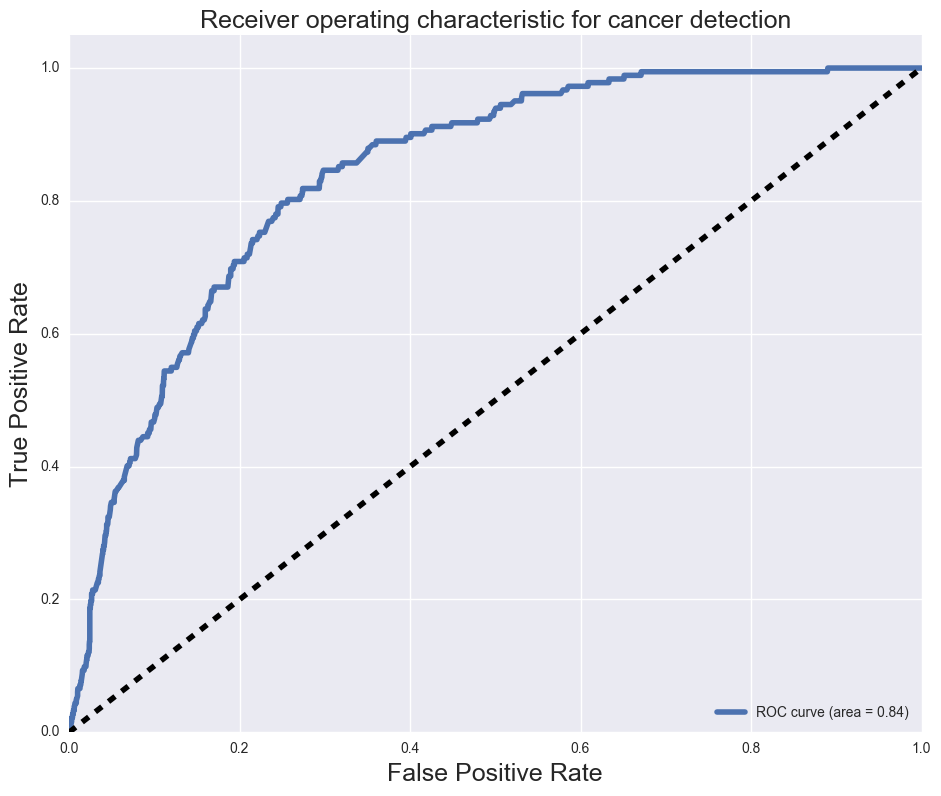

('cross val mean score is', 0.94658343832784131)

In [316]:
evaluate_model(gbc, X, y, names, test)

In [152]:
svc = SVC(kernel='linear')

In [317]:
model = gbc.fit(X, y)
y_pred = model.predict_proba(test)

In [326]:
X.head()

,Species,Trap,Tmax,PrecipTotal,AvgSpeed,length_of_day,TVar
0,2,1,88,0.0,6.5,896.0,28
1,3,1,88,0.0,6.5,896.0,28
2,3,6,88,0.0,6.5,896.0,28
3,2,13,88,0.0,6.5,896.0,28
4,3,13,88,0.0,6.5,896.0,28


In [325]:
model.feature_importances_

array([ 0.10396848,  0.23679474,  0.13732544,  0.05610948,  0.12507811,
        0.24367131,  0.09705244])

In [318]:
y_preds = pd.DataFrame(data=y_pred, columns=["WnvNotPresent", "WnvPresent"])

In [319]:
y_preds.head()

,WnvNotPresent,WnvPresent
0,0.990207,0.009793
1,0.996741,0.003259
2,0.989356,0.010644
3,0.998573,0.001427
4,0.998573,0.001427


In [320]:
df_out = pd.merge(df1, y_preds[['WnvPresent']], how = 'left', left_index=True, right_index=True )

In [296]:
df_plot = pd.merge(df1, y_preds[['WnvPresent']], how='left', left_index = True, right_index=True)

In [297]:
df_plot

,Unnamed: 0,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,...,AddressAccuracy,Tmax,Tmin,Tavg,DewPoint,PrecipTotal,AvgSpeed,length_of_day,TVar,WnvPresent
0,0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,...,9,86,61,74,56,0.00,10.0,910.0,25,0.007685
1,1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,...,9,86,61,74,56,0.00,10.0,910.0,25,0.003613
2,2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,...,9,86,61,74,56,0.00,10.0,910.0,25,0.006522
3,3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,...,9,86,61,74,56,0.00,10.0,910.0,25,0.001984
4,4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,...,9,86,61,74,56,0.00,10.0,910.0,25,0.001984
5,5,6,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TARSALIS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,...,9,86,61,74,56,0.00,10.0,910.0,25,0.001984
6,6,7,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",UNSPECIFIED CULEX,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,...,9,86,61,74,56,0.00,10.0,910.0,25,0.001984
7,7,8,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX ERRATICUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,...,9,86,61,74,56,0.00,10.0,910.0,25,0.002535
8,8,9,2008-06-11,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX PIPIENS/RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,...,9,86,61,74,56,0.00,10.0,910.0,25,0.005997
9,9,10,2008-06-11,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,...,9,86,61,74,56,0.00,10.0,910.0,25,0.002928


In [298]:
df_plot = df_plot[['Longitude', 'Latitude', 'Trap', 'Date', 'WnvPresent']]

In [299]:
df_plot["y_or_n"] = [1 if x > 0.1 else 0 for x in df_plot.WnvPresent]

/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [305]:
df_plot.dtypes

Longitude     float64
Latitude      float64
Trap           object
Date           object
WnvPresent    float64
y_or_n          int64
dtype: object

In [309]:
df_plot['Date'] = pd.to_datetime(df_plot['Date'])

/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [310]:
df_plot['year'] = df_plot.Date.dt.year

/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [312]:
df_plot['month'] = df_plot.Date.dt.month

/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [313]:
df_plot.head()

,Longitude,Latitude,Trap,Date,WnvPresent,y_or_n,year,month
0,-87.800991,41.95469,T002,2008-06-11,0.007685,0,2008,6
1,-87.800991,41.95469,T002,2008-06-11,0.003613,0,2008,6
2,-87.800991,41.95469,T002,2008-06-11,0.006522,0,2008,6
3,-87.800991,41.95469,T002,2008-06-11,0.001984,0,2008,6
4,-87.800991,41.95469,T002,2008-06-11,0.001984,0,2008,6


In [314]:
df_plot.to_csv('dfplot_randomstate15.csv', index=False)

In [321]:
df_out = df_out[['Id', 'WnvPresent']]

In [322]:
df_out.head()


,Id,WnvPresent
0,1,0.009793
1,2,0.003259
2,3,0.010644
3,4,0.001427
4,5,0.001427


In [294]:
df_plot.y_or_n.value_counts()

0    112273
1      4020
Name: y_or_n, dtype: int64

In [286]:
df_plot.describe()

,Longitude,Latitude,WnvPresent
count,116293.000000,116293.000000,116293.000000
mean,-87.693658,41.849389,0.019894
std,0.080699,0.106593,0.034370
min,-87.930995,41.644612,0.000391
25%,-87.750938,41.753411,0.003590
50%,-87.694991,41.862292,0.007899
75%,-87.648860,41.951866,0.020008
max,-87.531635,42.017430,0.553425


In [323]:
df_out.to_csv('evaluation2_gbc_randomstate42.csv', index=False)

0.947216613787
   class_0_pp  class_1_pp  pred_class_thresh10
0    0.711429    0.288571                    1
1    0.891541    0.108459                    1
2    0.995536    0.004464                    0
3    0.977633    0.022367                    0
4    0.963303    0.036697                    0
5    0.978420    0.021580                    0
6    0.990045    0.009955                    0
7    0.997598    0.002402                    0
8    0.998039    0.001961                    0
9    0.998240    0.001760                    0
             predicted present  predicted not present
present                    144                     38
not present                869                   2416
             precision    recall  f1-score   support

          0       0.98      0.74      0.84      3285
          1       0.14      0.79      0.24       182

avg / total       0.94      0.74      0.81      3467

(3467, 3)
       Species  Trap  Tmax  PrecipTotal  AvgSpeed  length_of_day
10156        1  

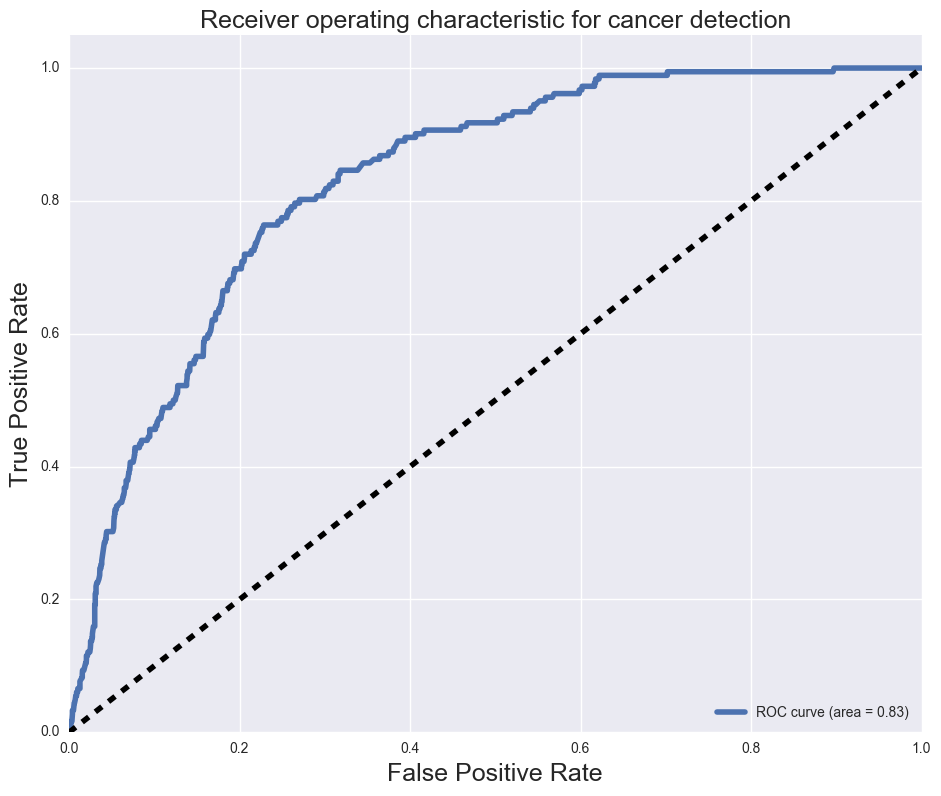

('cross val mean score is', 0.94672568569490212)

In [45]:
evaluate_model(gbc, X, y, names)

0.946351312374
   class_0_pp  class_1_pp  pred_class_thresh10
0    0.642486    0.357514                    1
1    0.912059    0.087941                    1
2    0.997693    0.002307                    0
3    0.979237    0.020763                    0
4    0.970193    0.029807                    0
5    0.983327    0.016673                    0
6    0.987240    0.012760                    0
7    0.998756    0.001244                    0
8    0.999036    0.000964                    0
9    0.999007    0.000993                    0
             predicted present  predicted not present
present                    146                     36
not present                874                   2411
             precision    recall  f1-score   support

          0       0.99      0.73      0.84      3285
          1       0.14      0.80      0.24       182

avg / total       0.94      0.74      0.81      3467

(3467, 3)
          0         1         2         3         4         5
0 -1.177499  1.3860

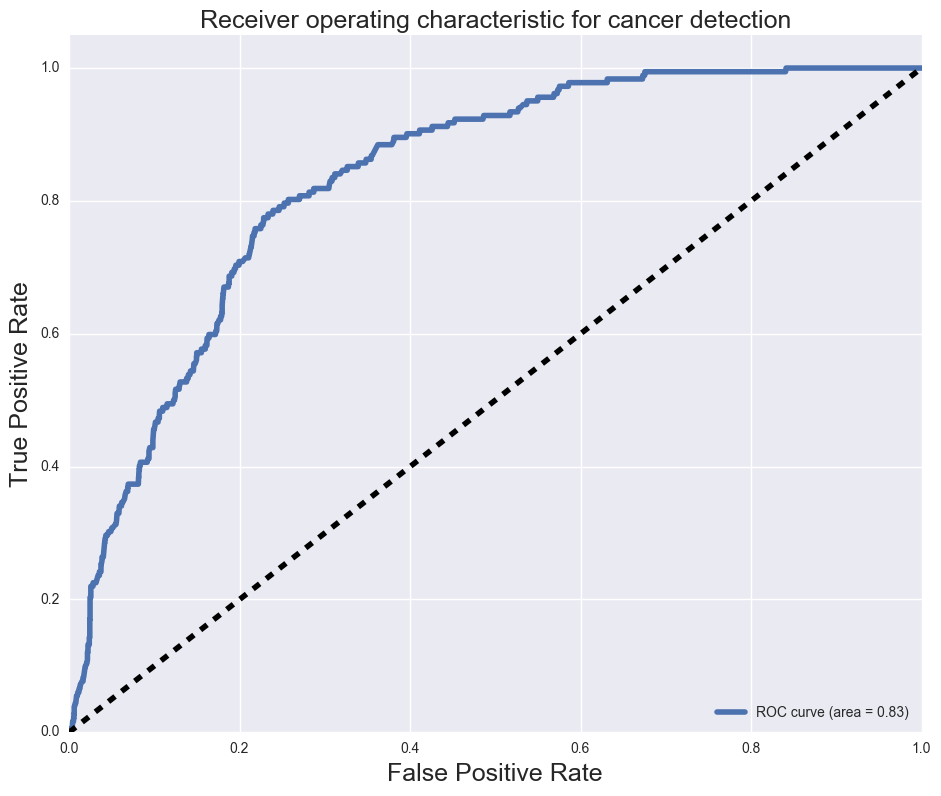

('cross val mean score is', 0.94715172110228085)

In [82]:
evaluate_model(gbc, X1, y, names)

## classifiers that don't work

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#using support vector machine to classify. Have set the kernel to poly as polynomial kernels are better for natural language processing
#have set degree to 2 to prevent overfitting

lr = LogisticRegression()
svc = SVC(kernel='poly')

0.947505047592
   class_0_pp  class_1_pp  pred_class_thresh10
0    0.868016    0.131984                    1
1    0.913140    0.086860                    1
2    0.964026    0.035974                    0
3    0.936162    0.063838                    1
4    0.895359    0.104641                    1
5    0.884625    0.115375                    1
6    0.945818    0.054182                    1
7    0.985460    0.014540                    0
8    0.985396    0.014604                    0
9    0.974741    0.025259                    0
             predicted present  predicted not present
present                    114                     68
not present               1294                   1991
             precision    recall  f1-score   support

          0       0.97      0.61      0.75      3285
          1       0.08      0.63      0.14       182

avg / total       0.92      0.61      0.71      3467

(3467, 3)
       Species  Trap  Tmax  PrecipTotal  AvgSpeed  length_of_day
10156        1  

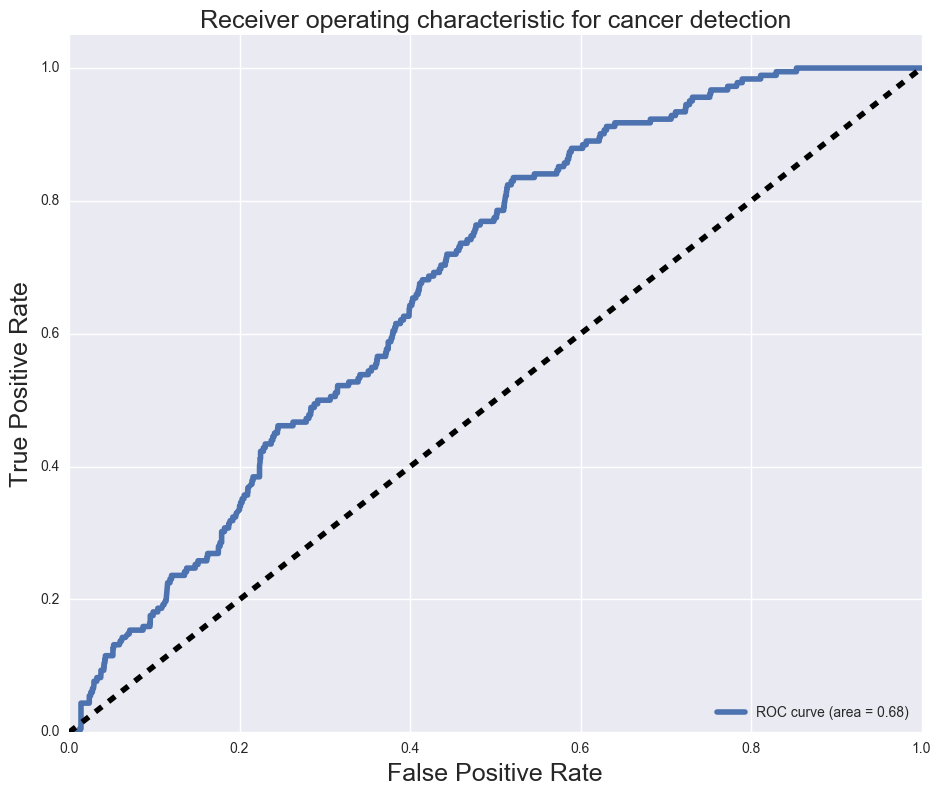

('cross val mean score is', 0.94757785746591716)

In [49]:
evaluate_model(lr, X, y, names)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=7)
model = svc.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print model.score(X_test, Y_test)
# Y_pp = pd.DataFrame(model.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
# Y_pp['pred_class_thresh10'] = [1 if x >= 0.05 else 0 for x in Y_pp.class_1_pp.values]
# X_test_df = pd.DataFrame(X_test)
conmat = np.array(confusion_matrix(Y_test, Y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=[names[0:2]],
                         columns=[names[2:]]) 
# print(Y_pp.iloc[0:10])
print confusion
print(classification_report(Y_test, Y_pred))
# print Y_pp.shape
# print X_test_df.head()
    
Y_score = model.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()
print "cross val mean score is", cross_val_score(model, X_train, Y_train, cv=5).mean()
    